# ライブラリのインポート

In [1]:
import pandas as pd  # 表データを扱うライブラリ
import numpy as np  # 数値計算用のライブラリ
import matplotlib.pyplot as plt # 可視化用のライブラリ
import seaborn as sns  #　綺麗に可視化することができるライブラリ
import warnings
warnings.filterwarnings('ignore')  # 警告を無視する
import time
import glob
import copy

### Jupyter Notebookで、pandasの表示行数や表示列数を変更する

In [3]:
#現在の最大表示行数の出力
print(pd.get_option("display.max_rows"))

#最大表示行数の指定（ここでは　１００行を指定）
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

1000000000


## データの読み込み

In [39]:
# BTCファイルの読み込みと連結
temp_btc_files = sorted(glob.iglob('./data/BTC/BTC_JPY_ohlcv_*.pkl'))
df_list = []
for btc_file in temp_btc_files:
    temp_df = pd.read_pickle(btc_file)
    df_list.append(temp_df)

btc_df = pd.concat(df_list)

In [40]:
# FX_BTCファイルの読み込みと連結
temp_fxbtc_files = sorted(glob.iglob('./data/FX_BTC/FX_BTC_JPY_ohlcv_*.pkl'))
df_list = []
for fxbtc_file in temp_fxbtc_files:
    temp_df = pd.read_pickle(fxbtc_file)
    df_list.append(temp_df)

fxbtc_df = pd.concat(df_list)

### データの中身を確認

In [41]:
btc_df.columns

Index(['op', 'hi', 'lo', 'cl', 'volume', 'volume_buy_sum', 'volume_sell_sum',
       'volume_buy', 'volume_sell'],
      dtype='object')

In [42]:
fxbtc_df

,op,hi,lo,cl,volume,volume_buy_sum,volume_sell_sum,volume_buy,volume_sell
timestamp,,,,,,,,,
2018-01-01 00:01:00+00:00,1884160.0,1889890.0,1884160.0,1888999.0,12.453978,6147.622671,4781.211680,3.171679,9.282299
2018-01-01 00:02:00+00:00,1888999.0,1889892.0,1884161.0,1885787.0,24.037741,5969.723071,4817.574471,11.493328,12.544412
2018-01-01 00:03:00+00:00,1885787.0,1886074.0,1880740.0,1882043.0,30.480556,5813.856981,4713.962894,18.496474,11.984082
2018-01-01 00:04:00+00:00,1882043.0,1886247.0,1882000.0,1882961.0,20.839496,5867.336392,4726.835472,11.470742,9.368754
2018-01-01 00:05:00+00:00,1882961.0,1884983.0,1879690.0,1882581.0,47.991520,6056.577528,4757.127376,32.205018,15.786502
...,...,...,...,...,...,...,...,...,...
2022-05-31 23:56:00+00:00,4092000.0,4092069.0,4088644.0,4090150.0,5.831372,145.452123,328.692970,4.356221,1.475150
2022-05-31 23:57:00+00:00,4090396.0,4093663.0,4089059.0,4091339.0,2.400130,145.222513,323.218699,0.772351,1.627779
2022-05-31 23:58:00+00:00,4091265.0,4094036.0,4089019.0,4089705.0,5.704033,147.471628,323.598319,4.748328,0.955704


# バックテストを行う

## bitFlyerのSFD乖離を利用した戦略
- bitFlyerの現物と先物Bitcoinの価格乖離抑制の仕組みであるSFDを利用した戦略

### データの整理を行う
・1分足で [timestamp, 現物open, 現物close, 先物open, 先物close, SFDの値] のデータフレームに整形する

In [43]:
temp_df = pd.merge(btc_df, fxbtc_df, on='timestamp', suffixes=['_btc', '_fxbtc'], how='inner', sort=True)
df = temp_df.drop(columns=['hi_btc', 'lo_btc', 'volume_btc', 'volume_buy_btc', 'volume_buy_sum_btc', \
                           'volume_sell_btc', 'volume_sell_sum_btc', 'hi_fxbtc', 'lo_fxbtc', 'volume_fxbtc', 'volume_buy_fxbtc', \
                           'volume_buy_sum_fxbtc', 'volume_sell_fxbtc', 'volume_sell_sum_fxbtc'])

In [44]:
df

,op_btc,cl_btc,op_fxbtc,cl_fxbtc
timestamp,,,,
2018-01-01 00:01:00+00:00,1674700.0,1677680.0,1884160.0,1888999.0
2018-01-01 00:02:00+00:00,1677680.0,1675009.0,1888999.0,1885787.0
2018-01-01 00:03:00+00:00,1675009.0,1670279.0,1885787.0,1882043.0
2018-01-01 00:04:00+00:00,1670279.0,1669403.0,1882043.0,1882961.0
2018-01-01 00:05:00+00:00,1669403.0,1669040.0,1882961.0,1882581.0
...,...,...,...,...
2022-05-31 23:56:00+00:00,4092100.0,4090385.0,4092000.0,4090150.0
2022-05-31 23:57:00+00:00,4090000.0,4092225.0,4090396.0,4091339.0
2022-05-31 23:58:00+00:00,4091997.0,4090869.0,4091265.0,4089705.0


In [45]:
df['sfd'] = (df['cl_fxbtc'] - df['cl_btc']) / df['cl_fxbtc']

In [46]:
df

,op_btc,cl_btc,op_fxbtc,cl_fxbtc,sfd
timestamp,,,,,
2018-01-01 00:01:00+00:00,1674700.0,1677680.0,1884160.0,1888999.0,0.111868
2018-01-01 00:02:00+00:00,1677680.0,1675009.0,1888999.0,1885787.0,0.111772
2018-01-01 00:03:00+00:00,1675009.0,1670279.0,1885787.0,1882043.0,0.112518
2018-01-01 00:04:00+00:00,1670279.0,1669403.0,1882043.0,1882961.0,0.113416
2018-01-01 00:05:00+00:00,1669403.0,1669040.0,1882961.0,1882581.0,0.113430
...,...,...,...,...,...
2022-05-31 23:56:00+00:00,4092100.0,4090385.0,4092000.0,4090150.0,-0.000057
2022-05-31 23:57:00+00:00,4090000.0,4092225.0,4090396.0,4091339.0,-0.000217
2022-05-31 23:58:00+00:00,4091997.0,4090869.0,4091265.0,4089705.0,-0.000285


In [47]:
#df.dropna(subset=['cl_btc', 'op_fxbtc', 'cl_fxbtc', 'sfd'], inplace=True)
df.fillna(method='ffill', inplace=True)

### SFDの値をプロットする

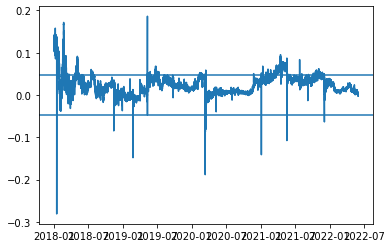

In [48]:
plt.plot(df['sfd'])
plt.axhline(y=0.048)
plt.axhline(y=-0.048)
plt.show()

In [49]:
# 直近3年分のデータにする
df = df.tail(60*24*365*3)

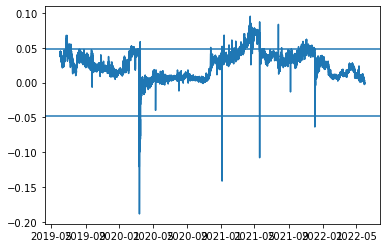

In [50]:
plt.plot(df['sfd'])
plt.axhline(y=0.048)
plt.axhline(y=-0.048)
plt.show()

# バックテストを行う

- ショートに関するentry/exit条件
  - ショートポジションのエントリー条件：0.048 < SFD
  - ショートポジションの手仕舞い条件：((0.04 > 0.048取得したSFDの現在の値) and ショートポジションを持っている)
- ロングに関するentry/exit条件
  - ロングポジションのエントリー条件：-0.048 > SFD
  - ロングポジションの手仕舞い条件：((0.0 < -0.048取得したSFDの現在の値) and ロングポジションを持っている)

In [25]:
def _market_order(size, next_open, timestamp):
    """
    do_backtest内でmarketオーダーを行う関数
    next_open : float
        次回のopenの価格（ここで成り行き注文が約定する
    size : float
        orderのサイズ　+ でロング　-でショート
    timestamp : Timestamp or Unixtime
        時刻
    """
    order = {
            "timestamp": timestamp,
            "size": size,
            "price": next_open
        }
    exec_history.append(order)  # itterableなオブジェクトは引数で与えなくても変更できる do_backtest内で使用する
    _change_position(size, next_open)

In [26]:
def _change_position(size, next_open):
    """
    オーダーをポジションに加える
    size : float
        orderのサイズ　+ でロング　-でショート
    """
    qty = position["qty"]
    avg = position["avgEntry"]
    new_qty = qty + size
    # 計算が必要になる
    if new_qty == 0:
        new_avg = 0
    else:
        # 同方向のポジション
        if qty * size >= 0:
            new_avg = (qty * avg + size * next_open) / (qty + size)
        # 違う方向のポジション
        else:
            if qty >= 0:
                # 元のポジションの方が大きい
                if new_qty > 0:
                    new_avg = avg
                # 今のポジションの方が大きい
                else:
                    new_avg = next_open
            # 元のポジションがマイナス
            else:
                if new_qty > 0:
                    new_avg = next_open
                # 今のポジションの方が大きい
                else:
                    new_avg = avg
    position["qty"] = new_qty
    position["avgEntry"] = new_avg

### バックテストを実行する関数

In [74]:
def do_backtest(df, order_lot): # 変数が必要であれば引数を追加する
    print(" ----   Do Backtest   ----")
    start = time.time()
    
    #  カラム名がtimestampでもtimeでも対応可能
#    if "datetime" in df.columns:
#        time_record = df.index
#    elif "timestamp" in df.columns :
#        time_record = df["timestamp"].index
#    elif "time" in df.columns :
#       time_record = df["time"].index
#   else:
#        print('else')
    timestamp = df.index
    
    # -------------------------- 必要なカラムの情報を入れてください ----------------------------
    op_btc = df["op_btc"].values
    cl_btc = df["cl_btc"].values
    op_fxbtc = df["op_fxbtc"].values
    cl_fxbtc = df["cl_fxbtc"].values
    sfd = df["sfd"].values
    
    # 各閾値
    l_th = -0.048 # ロングポジションのSFD
    s_th = 0.048 # ショートポジションのSFD
    ltp_th = 0.04 # ロングポジション手仕舞いのSFD
    stp_th = 0.0 # ショートポジション手仕舞いのSFD
    max_position_size = 0.001 # ポジションサイズ
    
    for i in range(len(df)-1):
        # for文はzipで回しても良い
        o_btc = op_btc[i]
        c_btc = cl_btc[i]
        o_fx = op_fxbtc[i]
        c_fx = cl_fxbtc[i]
        next_op_fxbtc = op_fxbtc[i+1] # 次のopen価格
        sfd_value = sfd[i]
        t = timestamp[i]
        qty = position["qty"]  # ポジションサイズ
        avgEntry = position["avgEntry"]  # 平均エントリー価格

        # -------------------------- ここから戦略 ----------------------------
        # longCondition = l_th > sfd              // -0.048 > sfdの値
        # shortCondition = s_th < sfd          // 0.048 < sfdの値
        # ロングポジションの手仕舞い条件：((0.0 < -0.048取得したSFDの現在の値) and ロングポジションを持っている)
        # ショートポジションの手仕舞い条件：((0.04 > 0.048取得したSFDの現在の値) and ショートポジションを持っている)

        # ポジションがない場合
        if qty == 0:
            if l_th > sfd_value and qty < max_position_size:
                # ロングポジションを持つ
                print('ロングポジション', t.strftime('%Y/%m/%d %H:%M'), str(sfd_value))
                _market_order(order_lot, next_op_fxbtc, t)
                print(position)
        elif s_th < sfd_value and qty > -max_position_size:
            #　ショートポジションを持つ
            print('ショートポジション', t.strftime('%Y/%m/%d %H:%M'), str(sfd_value))
            _market_order(-order_lot, next_op_fxbtc, t)
            print(position)
        # ポジションクロージング
        elif qty > 0 and ltp_th <= sfd_value:
            # ロングポジションの手仕舞い
            _market_order(-qty, next_op_fxbtc, t)
            print('ロング手仕舞い', t.strftime('%Y/%m/%d %H:%M'), str(sfd_value))
            print(position)
        elif qty < 0 and stp_th >= sfd_value:
            # ショートポジションの手仕舞い
            _market_order(-qty, next_op_fxbtc, t)
            print('ショート手仕舞い', t.strftime('%Y/%m/%d %H:%M'), str(sfd_value))
            print(position)
            
        
       
    print(" ----   finish backtest   ----")
    elapsed_time = time.time() - start
    print(f" ----   elapsed time: {elapsed_time}   ---- ")
    return pd.DataFrame(exec_history, columns=["timestamp", "size", "price"])

### バックテストの実行

In [75]:
# パラメータ
position = { "qty": 0, "avgEntry":0}
exec_history = []

exec_history_df = do_backtest(df, 0.001)

 ----   Do Backtest   ----
ショートポジション 2019/06/21 23:31 0.048038082067352855
{'qty': -0.001, 'avgEntry': 1125149.0}
ショート手仕舞い 2019/09/24 19:44 -0.00651798844385776
{'qty': 0.0, 'avgEntry': 0}
ショートポジション 2020/02/11 15:57 0.048011638772170864
{'qty': -0.001, 'avgEntry': 1174007.0}
ショート手仕舞い 2020/03/12 10:31 -0.010785352900680778
{'qty': 0.0, 'avgEntry': 0}
ロングポジション 2020/03/12 10:42 -0.0962386304960877
{'qty': 0.001, 'avgEntry': 661419.0}
ショートポジション 2020/03/15 22:00 0.058892421698674126
{'qty': 0.0, 'avgEntry': 0}
ロングポジション 2020/03/16 06:44 -0.05342325581395349
{'qty': 0.001, 'avgEntry': 537777.0}
ロング手仕舞い 2020/11/24 09:33 0.04177514611694196
{'qty': 0.0, 'avgEntry': 0}
ショートポジション 2020/11/24 12:25 0.04802822076872198
{'qty': -0.001, 'avgEntry': 2041000.0}
ロングポジション 2021/01/04 10:15 -0.14122328482833113
{'qty': 0.0, 'avgEntry': 0}
ロングポジション 2021/01/04 10:16 -0.14122328482833113
{'qty': 0.001, 'avgEntry': 3195533.0}
ロング手仕舞い 2021/01/06 04:24 0.042181490843691036
{'qty': 0.0, 'avgEntry': 0}
ショートポジション 20

In [55]:
exec_history_df

,timestamp,size,price
0,2019-06-21 23:31:00+00:00,-0.001,1125149.0
1,2019-09-24 19:44:00+00:00,0.001,862100.0
2,2020-02-11 15:57:00+00:00,-0.001,1174007.0
3,2020-03-12 10:31:00+00:00,0.001,744095.0
4,2020-03-12 10:42:00+00:00,0.001,661419.0
5,2020-03-15 22:00:00+00:00,-0.001,667709.0
6,2020-03-16 06:44:00+00:00,0.001,537777.0
7,2020-11-24 09:33:00+00:00,-0.001,2024577.0
8,2020-11-24 12:25:00+00:00,-0.001,2041000.0
9,2021-01-04 10:15:00+00:00,0.001,3195533.0


In [56]:
def make_pl(df, comfee=None, initial=100):
    """
    df : pd.DataFrame
        size : float or int sellはマイナス　buyはプラス
        time : unixtime or datetime
        price : float or int
    initial : 
        初期資金
    comfee ：
        手数料
    profit and loss を作成
    """

    print(" ----   Make PL Graph   ----")
    start = time.time()
    
    # それぞれの値をnumpyに変換
    size = df["size"].values
    timestamp = df["timestamp"].values
    price = df["price"].values
    pct_price = df["price"].pct_change().values

    # 計算用pl(空のarrayを作成)
    PLs = np.zeros(len(df))
    # 積み上げposition 
    cumsum_positon_size = np.cumsum(size)
    for i in range(1,len(df)):
        #　手数料がある場合
        if comfee:
            PLs[i] = pct_price[i]*cumsum_positon_size[i - 1] - abs(comfee*price[i]*cumsum_positon_size[i - 1])
        else:
            PLs[i] = pct_price[i]*cumsum_positon_size[i - 1]
    # 一回の損益    
    df["PL"] = PLs
    # 念のためコピーして初期資金分を足しておく
    tmp_PLs = copy.copy(PLs)
    tmp_PLs[0] += initial
    # 累積損益
    PL_graph = np.cumsum(tmp_PLs)
    df["PL_graph"] = PL_graph
    # 勝率
    tmp = PLs>0
    tmp = tmp.sum()
    win_rate = tmp/len(PLs)
    # 実現損益
    profit = PL_graph[-1]-initial
    # 平均損益
    avg_pl = profit/len(PLs)
    df["_cumsum"] = cumsum_positon_size
    print(f"取引回数:{len(PLs)} 実現損益:{profit} 勝率:{win_rate} 平均損益{avg_pl} ")
    elapsed_time = time.time() - start
    print(f" ----   elapsed time: {elapsed_time}   ---- ")
    return df, profit


In [57]:
pl, profit = make_pl(exec_history_df)

 ----   Make PL Graph   ----
取引回数:24 実現損益:0.003001078348731312 勝率:0.375 平均損益0.000125044931197138 
 ----   elapsed time: 0.0021941661834716797   ---- 


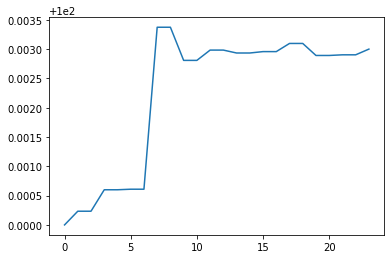

In [58]:
pl.PL_graph.plot();

In [78]:
pd.set_option('display.max_rows', 100000)
df['2020-03-12 00:00:00+0000':'2020-03-16 00:00:00+0000']

,op_btc,cl_btc,op_fxbtc,cl_fxbtc,sfd
timestamp,,,,,
2020-03-12 00:00:00+00:00,832225.0,833630.0,849703.0,851241.0,0.020689
2020-03-12 00:01:00+00:00,833630.0,834254.0,851099.0,851277.0,0.019997
2020-03-12 00:02:00+00:00,834338.0,834000.0,851250.0,850750.0,0.019689
2020-03-12 00:03:00+00:00,834385.0,834172.0,851037.0,850821.0,0.019568
2020-03-12 00:04:00+00:00,834285.0,834784.0,850829.0,851697.0,0.019858
2020-03-12 00:05:00+00:00,834944.0,834076.0,851696.0,850201.0,0.018966
2020-03-12 00:06:00+00:00,834076.0,834057.0,850367.0,850695.0,0.019558
2020-03-12 00:07:00+00:00,833998.0,832825.0,850695.0,849316.0,0.019417
2020-03-12 00:08:00+00:00,832830.0,832810.0,849383.0,849671.0,0.019844
